In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 5)
print(Path)
DATA_DIR = Path("/Users/mehulgoel/Documents/NYU_Courses/Reinforcement-Learning-Retail-Project/data/raw")

orders        = pd.read_csv(DATA_DIR / "orders.csv")
order_products = pd.read_csv(DATA_DIR / "order_products__prior.csv")
products      = pd.read_csv(DATA_DIR / "products.csv")
aisles        = pd.read_csv(DATA_DIR / "aisles.csv")
departments   = pd.read_csv(DATA_DIR / "departments.csv")

print("Orders shape:", orders.shape)
print("Order products shape:", order_products.shape)
print("Products shape:", products.shape)

<class 'pathlib.Path'>
Orders shape: (3421083, 7)
Order products shape: (32434489, 4)
Products shape: (49688, 4)


/var/folders/mf/pxwfzx596y5c99k9f98324k00000gn/T/ipykernel_55706/2388259417.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values, palette="viridis")


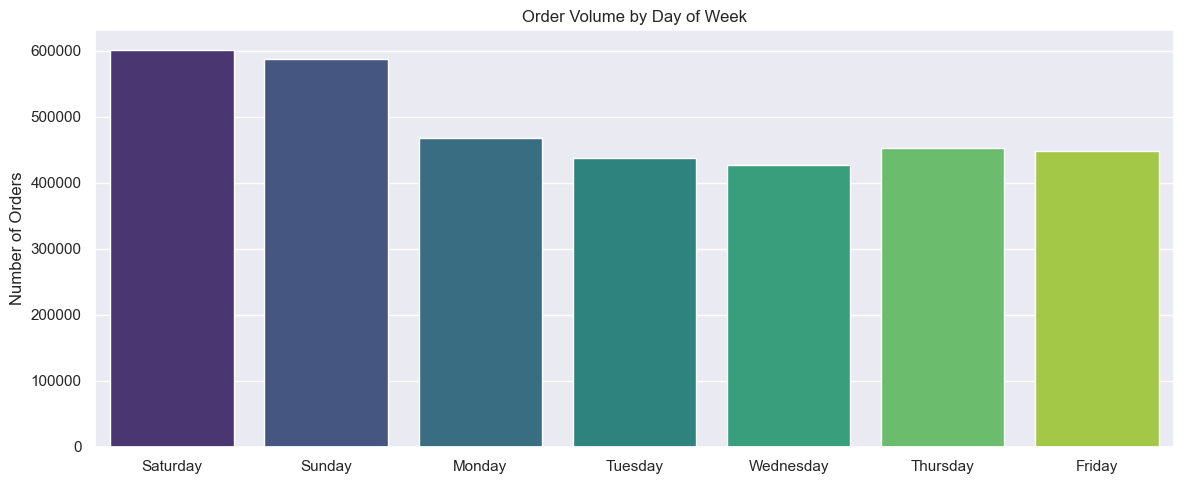

Weekend vs Weekday ratio: 0.532


In [9]:
day_map = {0:"Saturday", 1:"Sunday", 2:"Monday", 3:"Tuesday",
           4:"Wednesday", 5:"Thursday", 6:"Friday"}

orders['day_name'] = orders['order_dow'].map(day_map)
day_counts = orders['day_name'].value_counts().reindex(day_map.values())

plt.figure()
sns.barplot(x=day_counts.index, y=day_counts.values, palette="viridis")
plt.title("Order Volume by Day of Week")
plt.ylabel("Number of Orders")
plt.xlabel("")
plt.tight_layout()
plt.savefig("/Users/mehulgoel/Documents/NYU_Courses/Reinforcement-Learning-Retail-Project/docs/eda_orders_by_day.png", dpi=150)
plt.show()

print("Weekend vs Weekday ratio:",
      round(day_counts[['Saturday','Sunday']].sum() /
            day_counts[['Monday','Tuesday','Wednesday','Thursday','Friday']].sum(), 3))

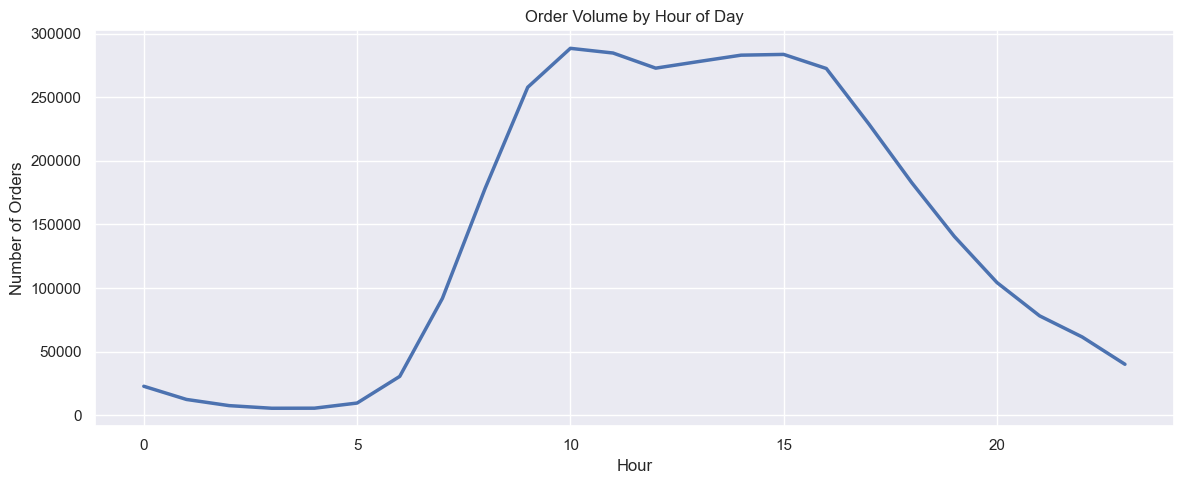

In [10]:
hour_counts = orders['order_hour_of_day'].value_counts().sort_index()

plt.figure()
sns.lineplot(x=hour_counts.index, y=hour_counts.values, linewidth=2.5)
plt.title("Order Volume by Hour of Day")
plt.ylabel("Number of Orders")
plt.xlabel("Hour")
plt.tight_layout()
plt.savefig("/Users/mehulgoel/Documents/NYU_Courses/Reinforcement-Learning-Retail-Project/docs/eda_orders_by_hour.png", dpi=150)
plt.show()

/var/folders/mf/pxwfzx596y5c99k9f98324k00000gn/T/ipykernel_55706/3098313226.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_volume.values[:10], y=dept_volume.index[:10], palette="magma")


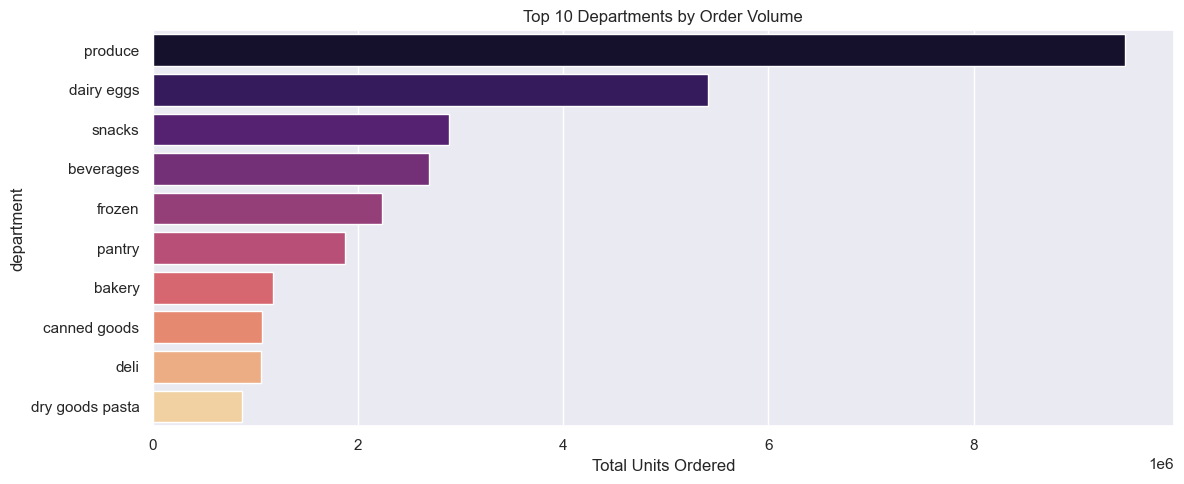

In [11]:
merged = order_products.merge(products, on='product_id') \
                       .merge(departments, on='department_id')

dept_volume = merged.groupby('department')['product_id'].count().sort_values(ascending=False)

plt.figure()
sns.barplot(x=dept_volume.values[:10], y=dept_volume.index[:10], palette="magma")
plt.title("Top 10 Departments by Order Volume")
plt.xlabel("Total Units Ordered")
plt.tight_layout()
plt.savefig("/Users/mehulgoel/Documents/NYU_Courses/Reinforcement-Learning-Retail-Project/docs/eda_top_departments.png", dpi=150)
plt.show()

Overall reorder rate: 58.97%

Reorder rate by department:
department
dairy eggs         0.670
beverages          0.653
produce            0.650
bakery             0.628
deli               0.608
pets               0.601
babies             0.579
bulk               0.577
snacks             0.574
alcohol            0.570
meat seafood       0.568
breakfast          0.561
frozen             0.542
dry goods pasta    0.461
canned goods       0.457
other              0.408
household          0.402
missing            0.396
international      0.369
pantry             0.347
personal care      0.321


/var/folders/mf/pxwfzx596y5c99k9f98324k00000gn/T/ipykernel_55706/3199123370.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_reorder.values, y=dept_reorder.index, palette="coolwarm")


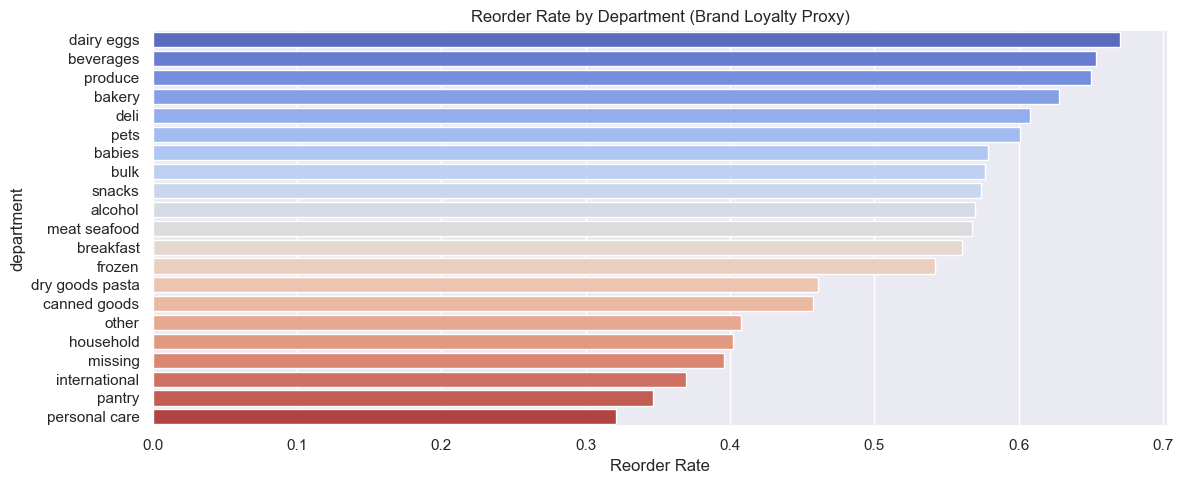

In [12]:
reorder_rate = order_products['reordered'].mean()
dept_reorder = merged.groupby('department')['reordered'].mean().sort_values(ascending=False)

print(f"Overall reorder rate: {reorder_rate:.2%}")
print("\nReorder rate by department:")
print(dept_reorder.round(3).to_string())

plt.figure()
sns.barplot(x=dept_reorder.values, y=dept_reorder.index, palette="coolwarm")
plt.title("Reorder Rate by Department (Brand Loyalty Proxy)")
plt.xlabel("Reorder Rate")
plt.tight_layout()
plt.savefig("/Users/mehulgoel/Documents/NYU_Courses/Reinforcement-Learning-Retail-Project/docs/eda_reorder_rates.png", dpi=150)
plt.show()

Mean basket size: 10.09
Median basket size: 8.00
Std: 7.53


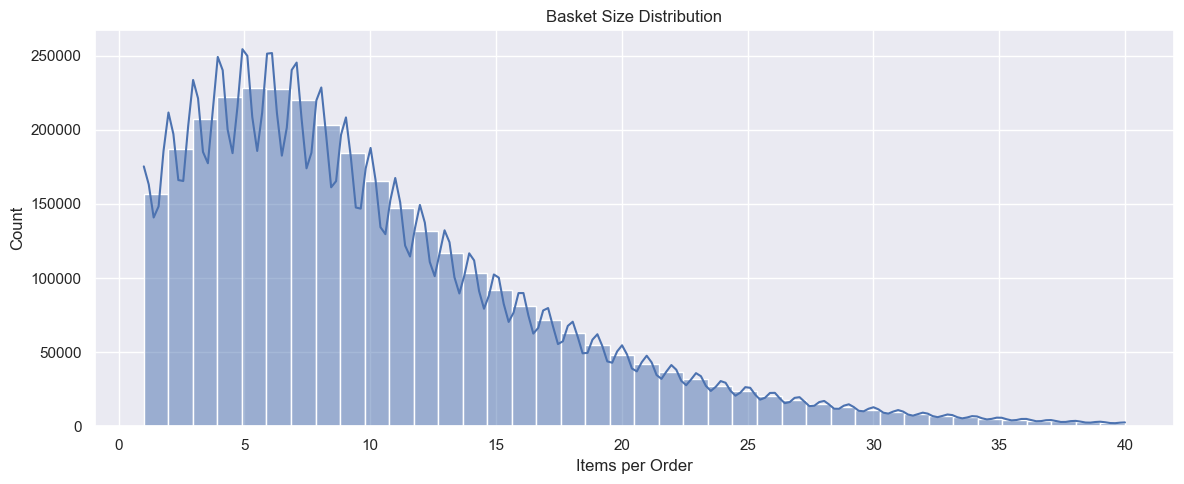

In [13]:
basket_sizes = order_products.groupby('order_id')['product_id'].count()

print(f"Mean basket size: {basket_sizes.mean():.2f}")
print(f"Median basket size: {basket_sizes.median():.2f}")
print(f"Std: {basket_sizes.std():.2f}")

plt.figure()
sns.histplot(basket_sizes[basket_sizes <= 40], bins=40, kde=True)
plt.title("Basket Size Distribution")
plt.xlabel("Items per Order")
plt.tight_layout()
plt.savefig("/Users/mehulgoel/Documents/NYU_Courses/Reinforcement-Learning-Retail-Project/docs/eda_basket_sizes.png", dpi=150)
plt.show()

In [14]:
weekend_ratio = day_counts[['Saturday','Sunday']].sum() / day_counts.sum()
top_depts = dept_volume.head(5).index.tolist()

print("=" * 50)
print("CALIBRATION PARAMETERS FOR env_config.yaml")
print("=" * 50)
print(f"Weekend demand multiplier:  {1 + weekend_ratio:.3f}")
print(f"Overall brand loyalty rate: {reorder_rate:.3f}")
print(f"Mean basket size:           {basket_sizes.mean():.2f} items")
print(f"Top 5 departments:          {top_depts}")
print("=" * 50)

CALIBRATION PARAMETERS FOR env_config.yaml
Weekend demand multiplier:  1.347
Overall brand loyalty rate: 0.590
Mean basket size:           10.09 items
Top 5 departments:          ['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen']
